In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from os.path import expanduser
import pickle
import random
import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
experiment_name = 'P3856'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

# RESULTS_DIR = '/media/big-ssd/results-P3856'
# IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)

IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

In [3]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### identified features

In [45]:
MAXIMUM_Q_VALUE = 0.01

In [46]:
# load the features identified
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_df = d['identifications_df']
idents_df = idents_df[(idents_df.run_name == run_name) & (idents_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [47]:
idents_df['excluded'] = idents_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_df = idents_df[(idents_df.excluded == False)]

In [48]:
print('{} identifications'.format(len(idents_df)))

8671 identifications


#### detected features

In [49]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_df = d['features_df']

In [50]:
features_df['excluded'] = features_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_df = features_df[(features_df.excluded == False)]

In [51]:
print('{} features detected'.format(len(features_df)))

73311 features detected


In [14]:
sets_d = {'detected':set(), 'identified':set()}

In [15]:
sets_d['detected'] = set(features_df.feature_id.tolist())
sets_d['identified'] = set(idents_df.feature_id.tolist())

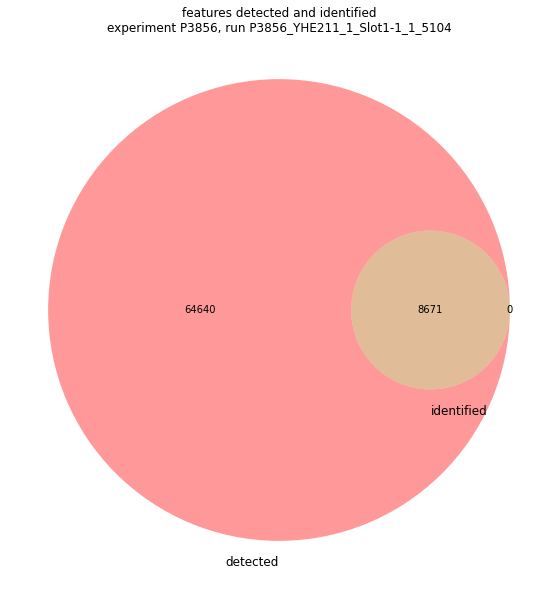

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected and identified\nexperiment {}, run {}'.format(experiment_name, run_name))

venn2([sets_d['detected'],sets_d['identified']], ('detected','identified'))

plt.show()

#### build the training set

In [17]:
# features detected but not identified
features_not_identified = sets_d['detected'] - sets_d['identified']
features_identified = sets_d['identified']

In [18]:
len(features_not_identified), len(features_identified)

(64640, 8671)

In [19]:
features_not_identified_df = features_df[features_df.feature_id.isin(features_not_identified)]
features_identified_df = features_df[features_df.feature_id.isin(features_identified)]

In [20]:
SAMPLE_SIZE = 8500

In [21]:
features_not_identified_df = features_not_identified_df.sample(n=SAMPLE_SIZE)
features_not_identified_df['category'] = 0

features_identified_df = features_identified_df.sample(n=SAMPLE_SIZE)
features_identified_df['category'] = 1

In [27]:
combined_df = pd.concat([features_not_identified_df, features_identified_df], axis=0, sort=False, ignore_index=True)

In [28]:
combined_df.isna().sum()

mono_mz_lower                               0
mono_mz_upper                               0
scan_apex                                   0
scan_lower                                  0
scan_upper                                  0
rt_apex                                     0
rt_lower                                    0
rt_upper                                    0
intensity_without_saturation_correction     0
intensity_with_saturation_correction        0
mono_intensity_adjustment_outcome           0
mono_mz                                     0
isotopic_peaks                              0
coelution_coefficient                      38
mobility_coefficient                       51
scan_df                                     0
rt_df                                       0
monoisotopic_mz                             0
charge                                      0
monoisotopic_mass                           0
feature_intensity                           0
envelope                          

In [29]:
combined_df.fillna(0, inplace=True)

In [30]:
feature_ids_l = combined_df.feature_id.tolist()

In [31]:
train_proportion = 0.8
val_proportion = 0.1

In [32]:
train_n = round(len(feature_ids_l) * train_proportion)
val_n = round(len(feature_ids_l) * val_proportion)

In [33]:
train_set = random.sample(feature_ids_l, train_n)
val_test_set = list(set(feature_ids_l) - set(train_set))
val_set = random.sample(val_test_set, val_n)
test_set = list(set(val_test_set) - set(val_set))

In [34]:
train_df = combined_df[combined_df.feature_id.isin(train_set)]
valid_df = combined_df[combined_df.feature_id.isin(val_set)]
test_df = combined_df[combined_df.feature_id.isin(test_set)]

In [35]:
print('train: {} ({}%), validation: {} ({}%), test: {} ({}%)'.format(len(train_df), round(len(train_df)/len(combined_df)*100), len(test_df), round(len(test_df)/len(combined_df)*100), len(valid_df), round(len(valid_df)/len(combined_df)*100)))


train: 13600 (80%), validation: 1700 (10%), test: 1700 (10%)


In [10]:
input_names = ['deconvolution_score','coelution_coefficient','mobility_coefficient','isotope_count']

In [37]:
X_train = train_df[input_names].to_numpy()
y_train = train_df[['category']].to_numpy()[:,0]

In [38]:
X_valid = valid_df[input_names].to_numpy()
y_valid = valid_df[['category']].to_numpy()[:,0]

In [39]:
X_test = test_df[input_names].to_numpy()
y_test = test_df[['category']].to_numpy()[:,0]

In [49]:
# define the keras model
model = Sequential()
model.add(BatchNormalization(input_shape=(4,)))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [50]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [51]:
# fit the keras model on the dataset
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=4000, 
                    batch_size=512,
                    verbose=0)

best validation loss: 0.3131
best validation accuracy: 0.8782


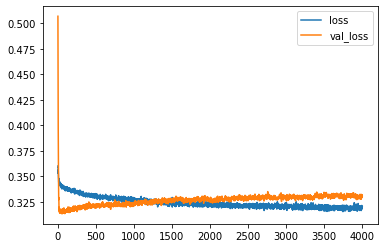

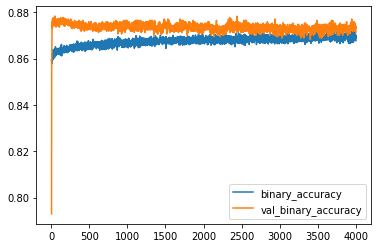

In [52]:
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
print(("best validation loss: {:0.4f}"+"\nbest validation accuracy: {:0.4f}").format(history_df['val_loss'].min(), history_df['val_binary_accuracy'].max()))

#### evaluate the model on the test data

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

#### save the model

In [53]:
model.save("{}/feature_classifier".format(expanduser('~')))

INFO:tensorflow:Assets written to: feature_classifier/assets


#### load the model

In [3]:
MODEL_DIR = '{}/feature_classifier'.format(expanduser('~'))

In [4]:
reconstructed_model = keras.models.load_model(MODEL_DIR)

#### use the model to classify the 3DID features

In [5]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)
FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)
FEATURES_3DID_IDENT_FILE = '{}/exp-{}-run-{}-features-3did-ident.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

In [6]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']
# features_3did_metadata = d['metadata']

In [7]:
features_3did_metadata = d['metadata']

In [8]:
features_3did_df.fillna(0, inplace=True)

In [11]:
predictions = reconstructed_model.predict(features_3did_df[input_names].to_numpy())

In [12]:
features_3did_df['prediction'] = predictions

In [13]:
features_3did_df.sample(n=3)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,deconvolution_score,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction
37438,971.973291,972.035206,109.0,92.0,148.0,1894.443005,1881.739916,1911.379317,1012,1012,...,851.372060,"{'mz_lower': 969.9033949673435, 'mz_upper': 97...",440025601,"{'mz_lower': 970.4531437110621, 'mz_upper': 97...","[{'scan': 91, 'intensity': 272, 'filtered_inte...",0.941638,"[{'frame_id': 16762, 'retention_time_secs': 18...",0.973916,37438,0.879380
514102,666.349477,666.391924,642.0,617.0,659.0,2177.577791,2172.577791,2182.870203,770,770,...,83.179964,"{'mz_lower': 664.2745707831714, 'mz_upper': 66...",290007490,"{'mz_lower': 664.82431952689, 'mz_upper': 664....","[{'scan': 611, 'intensity': 44, 'filtered_inte...",0.992461,"[{'frame_id': 19412, 'retention_time_secs': 21...",0.985746,514102,0.001329
526292,849.465422,849.519534,396.0,372.0,406.0,1789.116906,1785.411382,1794.116906,4549,4549,...,649.692991,"{'mz_lower': 848.8975961378316, 'mz_upper': 85...",380002173,"{'mz_lower': 849.4473448815502, 'mz_upper': 84...","[{'scan': 359, 'intensity': 9, 'filtered_inten...",0.993799,"[{'frame_id': 15722, 'retention_time_secs': 17...",0.986814,526292,0.840722


In [14]:
features_3did_df['identification_predicted'] = features_3did_df.apply(lambda row: row.prediction >= 0.5, axis=1)

In [15]:
features_3did_df.sample(n=3)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction,identification_predicted
732212,698.349444,698.393930,687.0,664.0,703.0,1880.151633,1867.452436,1885.151633,880,880,...,"{'mz_lower': 696.2344011217491, 'mz_upper': 69...",300015367,"{'mz_lower': 696.7841498654677, 'mz_upper': 69...","[{'scan': 647, 'intensity': 45, 'filtered_inte...",0.978210,"[{'frame_id': 16527, 'retention_time_secs': 18...",0.938490,732212,0.525583,True
135506,735.284566,735.331405,666.0,651.0,676.0,2052.674951,2045.792085,2059.025818,821,821,...,"{'mz_lower': 733.2225753333186, 'mz_upper': 73...",320022330,"{'mz_lower': 733.7723240770372, 'mz_upper': 73...","[{'scan': 639, 'intensity': 194, 'filtered_int...",0.953243,"[{'frame_id': 18227, 'retention_time_secs': 20...",0.968631,135506,0.002139,False
94884,936.992878,937.052565,152.0,128.0,175.0,1962.182328,1959.536860,1972.237702,590,590,...,"{'mz_lower': 936.8403915276402, 'mz_upper': 94...",420021035,"{'mz_lower': 937.3901402713589, 'mz_upper': 93...","[{'scan': 124, 'intensity': 158, 'filtered_int...",0.998815,"[{'frame_id': 17332, 'retention_time_secs': 19...",0.992838,94884,0.000866,False


In [16]:
sets_d = {'detected':set(), 'identification predicted':set()}

In [17]:
sets_d['detected'] = set(features_3did_df.feature_id.tolist())
sets_d['identification predicted'] = set(features_3did_df[(features_3did_df.identification_predicted == True)].feature_id.tolist())

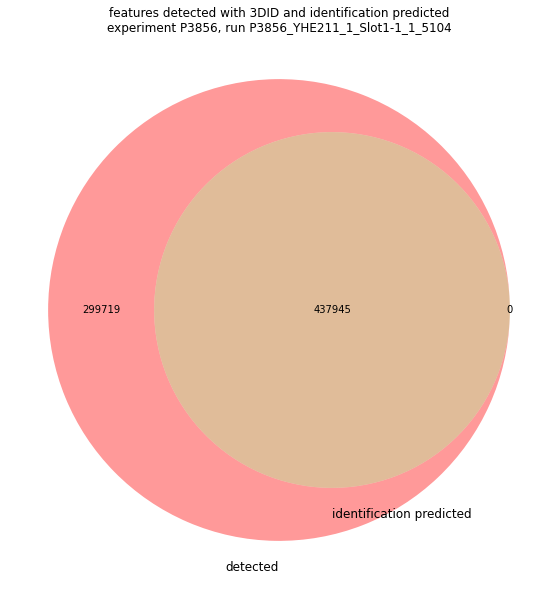

In [18]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected with 3DID and identification predicted\nexperiment {}, run {}'.format(experiment_name, run_name))

venn2([sets_d['detected'],sets_d['identification predicted']], ('detected','identification predicted'))

plt.show()

In [19]:
# filter out the features unlikely to be identified
features_3did_df = features_3did_df[(features_3did_df.identification_predicted == True)]

In [20]:
info = []
info.append(('experiment_base_dir', EXPERIMENT_DIR))
info.append(('experiment_name', experiment_name))
info.append(('run_name', run_name))
info.append(('model', MODEL_DIR))
info.append(('processor', 'paper 4 - feature classifier.ipynb'))
info.append(('processed', time.ctime()))

In [21]:
print('writing {} features to {}'.format(len(features_3did_df), FEATURES_3DID_IDENT_FILE))
content_d = {'features_df':features_3did_df, 'metadata':info}
with open(FEATURES_3DID_IDENT_FILE, 'wb') as handle:
    pickle.dump(content_d, handle)

writing 437945 features to /media/big-ssd/experiments/P3856/features-3did/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-ident.pkl
